# Centerline migration analysis

This code computes channel migration over time. 

### author:
Martin LEMAY
martin.lemay@mines-paris.org

### Related publication

If you use this script, please refer to the following publication:
- Lemay, M., Grimaud, J. L., Cojan, I., Rivoirard, J., & Ors, F. (in press) Submarine channel stacking patterns controlled by the autogenic 3D kinematics of meander bends. GSL special issue on meandering systems.

### Dependencies
- dtw-python 1.1.10

#### Python modules import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import host_subplot
import seaborn as sns
sns.set()

from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter

import scipy.stats as stats
import dtw

import Centerline_collection
import Cl_point
import plot_functions as plot
import centerline_process_function as cpf

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



#### Input parameters

In [5]:
root += "/article_strati_vs_kinetics/"
filename = "BendMigration.csv"

root = "path/to/working/directory/"
filename = "inputFileName.csv"

# Parameters
width = 80 # channel width
depth_max = 2 # channel max depth

spacing = 20 # spacing between channel point
smooth_distance = 1.5*width # curvature and channel point location smoothing distance
sinuo_thres = 1.05 # threshold for bends
lag = 1 #int((smooth_distance/spacing) / 2) # minimum lag between 2 consecutive inflection points
nb_apex = 20 # number of points (furthest or max curvature) among which is the apex
dmax = 0.7*width # maximal distance between 2 consecutive centroid at iterations n and n+1
smooth_trajec_window = 2
recompute_apex = False #5 # number of points per bend to recompute apex location to get consistency between bends
apex_proba_ponds=(2.,1.,1.) # curvature, amplitude, length

bend_evol_validity = 2 # minimum number of bends in a bend_evolution


# channel point tracking parameters
dmax = 3*width # max allowed distance between points at centerlines t and t+1
distance_weight = 1.0 # weight on the distance between points at centerlines t and t+1
vel_perturb_weight = 0 # weight on the velocity perturbation
curvature_weight = 0.0 # weight on the curvature difference between pointsat centerlines t and t+1

### Import data, create centerline collections and apply dtw to track channel points

In [6]:
# create the centerline collection object from CenterlineProps file
cl_collec = Centerline_collection.Centerline_collection(
                root + filename, spacing, smooth_distance,
                lag=lag, nb=nb_apex, sinuo_thres=sinuo_thres, width=width,
                apex_proba_ponds=apex_proba_ponds,
                compute_curvature=True, interpol_props=True, plot_curvature=False)




cl_collec.match_centerlines(dmax = dmax, distance_weight=distance_weight,
                            vel_perturb_weight=vel_perturb_weight,
                            curvature_weight=curvature_weight,
                            window = 5, pattern="asymmetric")

Centerline 1785 initialized
Bends found
Centerline 1839 initialized
Bends found
Data imported


True

### Plot centerlines

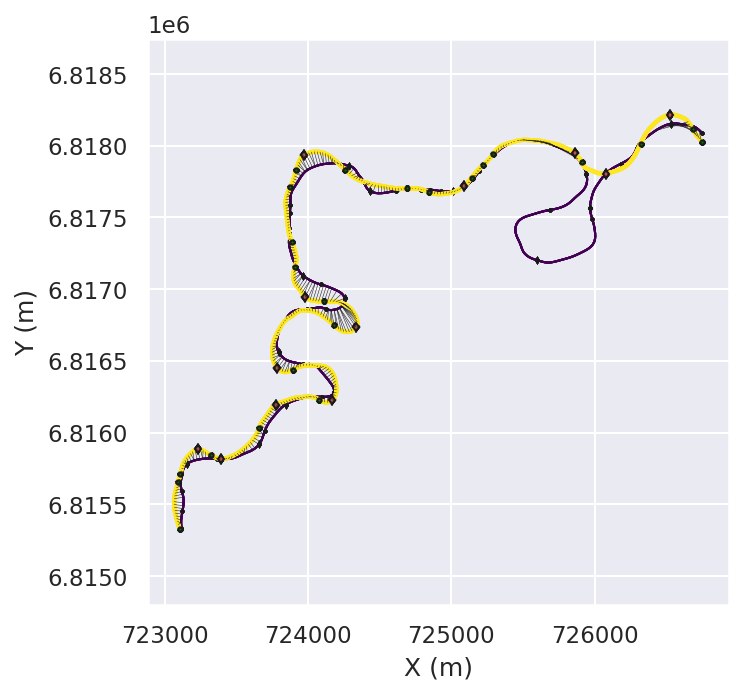

In [7]:
cmap = cm.get_cmap("viridis")

domain = [[],[]] # window range
plot.plot_centerline_collection(False, cl_collec, domain, nb_cl=10, show = True,
                                    annotate = False, plot_apex = True, plot_inflex = True,
                                    plot_middle = False, plot_centroid = False, annot_text_size=10,
                                    color_bend = False, plot_apex_trajec = True,
                                    plot_centroid_trajec = False, plot_section = False, cmap_name="viridis",
                                    plot_warping = True)

### Compute channel point migration

Number of points: 351
Average migration distance: 46.70 m
Median migration distance: 31.15 m


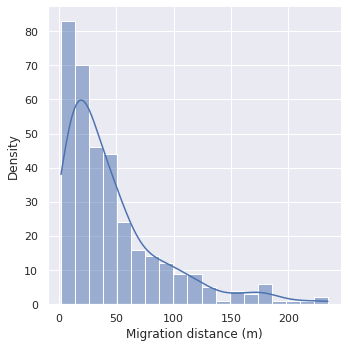

In [14]:
for i, key2 in enumerate(cl_collec.all_iter[:-1]):
  key1 = cl_collec.all_iter[i+1]

  ctls1 = cl_collec.centerlines[key1]
  ctls2 = cl_collec.centerlines[key2]

  distance = []
  for index1, index2 in enumerate(ctls1.index_cl_pts_prev_centerline):
    if not np.isfinite(index1) or not np.isfinite(index2):
      continue

    pt1 = ctls1.cl_points[int(index1)].pt
    pt2 = ctls2.cl_points[int(index2)].pt

    # migration distance
    distance += [cpf.distance(pt1, pt2)]

# Print results
print("Number of points: %s"%(len(distance)))
print("Average migration distance: %.2f m"%(np.mean(distance)))
print("Median migration distance: %.2f m"%(np.median(distance)))

# plot histograms of migration distance
sns.displot(distance, kind="hist", kde=True)
plt.xlabel("Migration distance (m)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()
